In [1]:
%pip install jumpmodels > /dev/null
# import neccessary library
from general_used_functions import *


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Model Training 

Successfully patched jumpmodels type checks


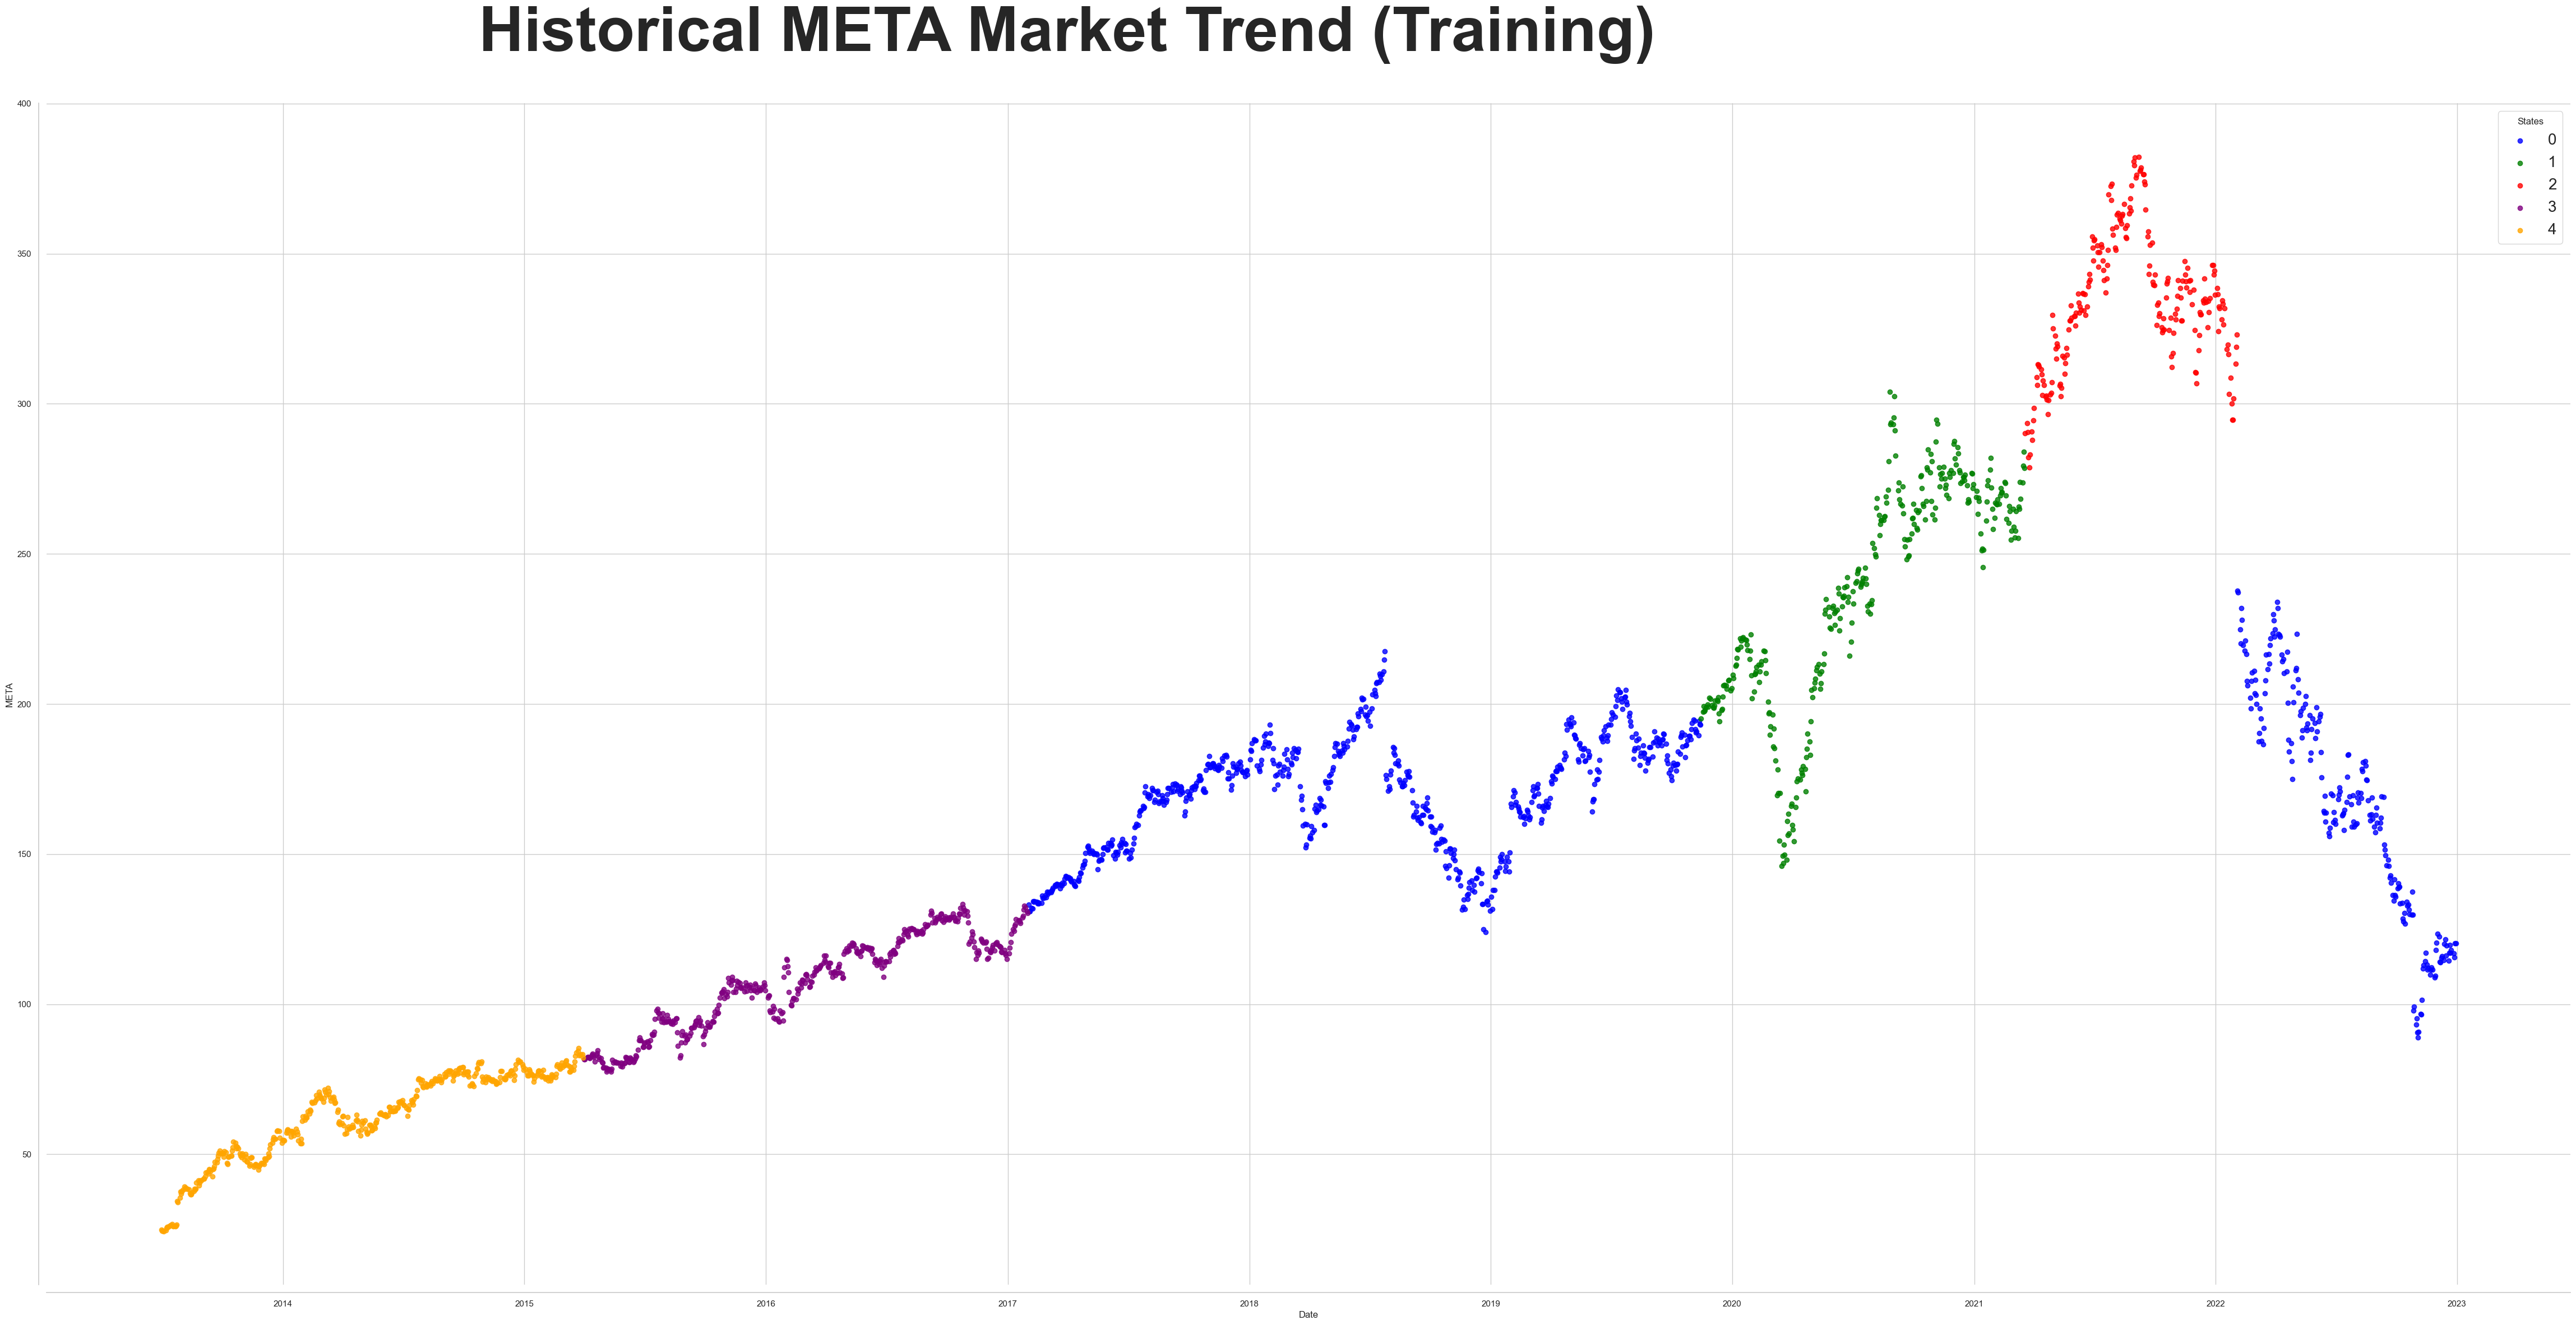

In [2]:
# Load training data
config_data = load_config_file()
stock_list = config_data['stock_dict']
training_stock_df = load_training_data()

# Import wrapper instead of directly importing from jumpmodels
import jumpmodels_wrapper
from jumpmodels.sparse_jump import SparseJumpModel
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd

def SJM_training(stock, train_df, n_components=2, max_feats=3, jump_penalty=50.0):
    """Train a Sparse Jump Model for regime identification with proper preprocessing"""
    # Feature processing pipeline
    clipper = DataClipperStd(mul=3.)
    scaler = StandardScalerPD()
    
    # Process features
    features = train_df.drop(columns=['date'])
    features_processed = scaler.fit_transform(clipper.fit_transform(features))

    # Initialize and train SJM with recommended parameters
    model = SparseJumpModel(
        n_components=n_components,
        jump_penalty=jump_penalty,
        max_iter=10000, 
        random_state=42
    )
    
    # Fit model with returns series for regime sorting
    ret_ser = train_df[stock]  # Ensure returns are calculated
    model.fit(features_processed, ret_ser=ret_ser, sort_by="cumret")

    # Get regime labels
    hidden_states = model.labels_

    # Build states DataFrame
    states = pd.DataFrame({
        'Date': train_df['date'],
        stock: train_df[stock],
        'states': hidden_states
    })

    # Visualize results
    plot_market_regime(states, stock, isHMM=False)
    
    return model, states, scaler, clipper

stock = 'META'
target_columns = config_data['selected_features_dict'][stock]
train_df = training_stock_df[stock][target_columns]

# Train with recommended parameters
model, states, scaler, clipper = SJM_training(
    stock, 
    train_df,
    n_components=5,  
    jump_penalty=50.0
)


In [3]:
def save_SJM_states_excel(stock, states, is_test=False):
    """Save regime states with SJM-specific directory"""
    DATA_DIR = os.path.join(os.getcwd(), 'data', 'SJM_states', stock)
    os.makedirs(DATA_DIR, exist_ok=True)
    
    subscript = "(Testing)" if is_test else "(Training)"
    states.to_excel(
        os.path.join(DATA_DIR, f"{stock}_SJM_states{subscript}.xlsx"), 
        index=False
    )

def save_SJM_model(stock, model, scaler, clipper):
    """Save SJM model with preprocessing objects"""
    if not isinstance(model, SparseJumpModel):
        raise ValueError("Model must be an instance of SparseJumpModel")
    
    MODEL_DIR = os.path.join(os.getcwd(), 'model')
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    joblib.dump(
        {'model': model, 'scaler': scaler, 'clipper': clipper},
        os.path.join(MODEL_DIR, f'{stock}_SJM_model.joblib')
    )
    
# Save the model and states 
save_SJM_states_excel(stock, states)
save_SJM_model(stock, model, scaler, clipper)

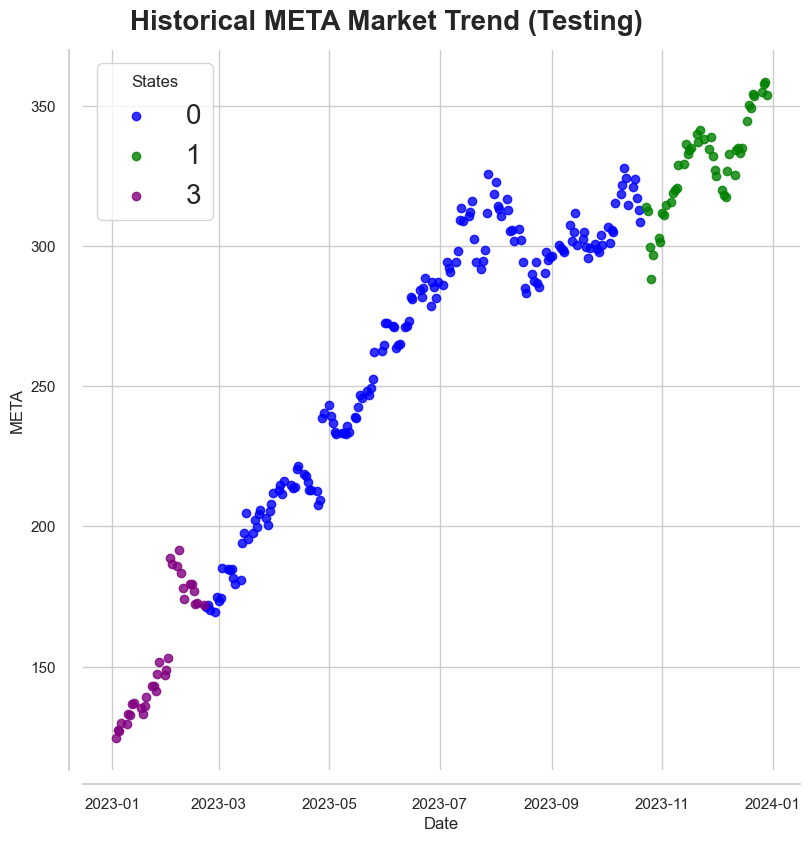

In [4]:
def SJM_testing(stock, test_df, model_package):
    """Test using persisted preprocessing"""
    model = model_package['model']
    scaler = model_package['scaler']
    clipper = model_package['clipper']
    
    features = test_df.drop(columns=['date'])
    features_processed = scaler.transform(clipper.transform(features))
    
    # Use online prediction for testing data
    hidden_states = model.predict_online(features_processed)
    
    # Build states DataFrame
    states = pd.DataFrame({
        'Date': test_df['date'],
        stock: test_df[stock],
        'states': hidden_states
    })
    
    # Visualize results with testing flag
    plot_market_regime(states, stock, is_test=True, isHMM=False)
    
    return states

# Load testing data (only need to load once)
config_data = load_config_file()
testing_stock_df = load_testing_data()
target_columns = config_data['selected_features_dict'][stock]
test_df = testing_stock_df[stock][target_columns]

# Load model from correct SJM path
model_package = joblib.load(f'model/{stock}_SJM_model.joblib')
states = SJM_testing(stock, test_df, model_package)

# Save the testing states
save_SJM_states_excel(stock, states, is_test=True) 
